In [1]:
import sys
import pickle
import numpy as np
import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()  # if not use with this line, "AttributeError: 'int' object has no attribute 'value'" 
# tf.disable_eager_execution()
import PIL.Image
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


##### Set the path to directory containing code of this case

In [3]:
new_path = r'/home/users/suihong/11-2DGANSim_localD_GANSim_MPS_muddrape/GANSimForAllConditioning/' 
sys.path.append(new_path)

### 1. Fetch dataset

#### Set the path to data directory; this directory includes two datasets: "trainingdata" and "testdata"

In [4]:
data_dir_test = '/scratch/users/suihong/Mud_drape_Channels/PreparedDataset/'

In [5]:
# Initialize TensorFlow session.
tf.InteractiveSession()

import dataset

test_set = dataset.load_dataset(data_dir=data_dir_test, verbose=True, tfrecord_dir='TestData', 
                                 cond_label = True, cond_well = True, cond_prob = True,
                                 well_enlarge = False, shuffle_mb = 0, prefetch_mb = 0)

# labels are from -1 to 1
test_dict = test_set.get_minibatch_np(minibatch_size = 1000, lod = 0)  
facies_test = test_dict['real']
labels_test = test_dict['label']
probimgs_test = test_dict['prob']
wellfaciesimgs_test = test_dict['well']


pb_cf_ratio = labels_test[:, 0] # pb_cf_ratio has been normalized
pb_cf_ratio = (pb_cf_ratio / 2 + 0.5) * (2 - 0.2) + 0.2
fp_prop = labels_test[:, 1] # fp_prop has been normalized
fp_prop = (fp_prop / 2 + 0.5) * (0.82 - 0.5) + 0.5


Streaming data using dataset.TFRecordDataset...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
Dataset shape = [1, 64, 64]
Dynamic range = [0, 2]
Label size    = 0


In [6]:

facies_test_newcode = np.where(facies_test>2, facies_test-1, facies_test)
wellfaciesimgs_test_newcode = np.where(wellfaciesimgs_test>3, wellfaciesimgs_test-1, wellfaciesimgs_test)

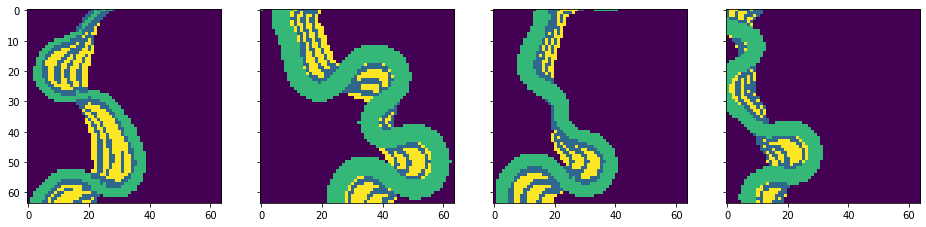

In [7]:
# Create a figure with 6 plot areas
fig, axes = plt.subplots(ncols=4, nrows=1, sharey='row')
fig.set_size_inches(16, 4, forward=True)

axes[0].imshow(facies_test_newcode[0, 0].astype(np.float32))
axes[1].imshow(facies_test_newcode[1, 0].astype(np.float32))
axes[2].imshow(facies_test_newcode[2, 0].astype(np.float32))
axes[3].imshow(facies_test_newcode[3, 0].astype(np.float32))

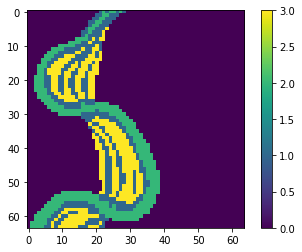

In [8]:
plt.imshow(facies_test_newcode[0, 0].astype(np.float32))
plt.colorbar()

(array([  1.,   0.,   1.,   1.,   1.,   1.,   2.,   5.,   3.,   3.,   6.,
          9.,  10.,  18.,  19.,  22.,  22.,  29.,  42.,  46.,  62.,  58.,
         70.,  85.,  75.,  81., 122., 102.,  82.,  22.]),
 array([0.43652344, 0.44934896, 0.46217448, 0.475     , 0.4878255 ,
        0.50065106, 0.51347655, 0.5263021 , 0.5391276 , 0.55195314,
        0.5647786 , 0.5776042 , 0.59042966, 0.6032552 , 0.6160807 ,
        0.62890625, 0.6417318 , 0.6545573 , 0.66738284, 0.6802083 ,
        0.6930339 , 0.70585936, 0.7186849 , 0.7315104 , 0.74433595,
        0.75716144, 0.769987  , 0.7828125 , 0.795638  , 0.8084635 ,
        0.82128906], dtype=float32),
 <a list of 30 Patch objects>)

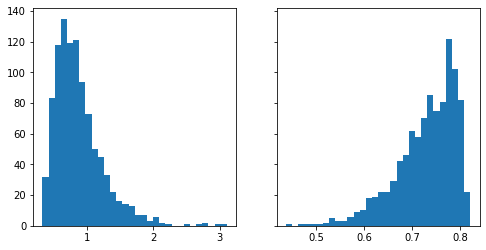

In [9]:
# Create a figure with 6 plot areas
fig, axes = plt.subplots(ncols=2, nrows=1, sharey='row')
fig.set_size_inches(8, 4, forward=True)

axes[0].hist(pb_cf_ratio, bins = 30)
axes[1].hist(fp_prop, bins = 30)


In [10]:
print(facies_test.shape)
print(pb_cf_ratio.shape)
print(fp_prop.shape)

(1000, 1, 64, 64)
(1000,)
(1000,)


### 2. Import pre-trained Network

In [11]:
GANSim_dir = '/scratch/users/suihong/Mud_drape_Channels/TrainedModels/062-prog_2gpu-CondWell_w100-CondProb/'
GANSim_name = 'network-snapshot-013440.pkl' 

In [12]:
# Initialize TensorFlow session.
tf.InteractiveSession()

with tf.device('/gpu:0'):   
    # Import networks.
    with open(GANSim_dir + GANSim_name, 'rb') as file:
        G, D, Gs = pickle.load(file)
    

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [13]:
print(Gs.input_shapes)

print(Gs.output_shapes)

[[None, 8, 4, 4], [None, 2, 64, 64], [None, 2, 64, 64], [None, 3, 64, 64]]
[[None, 4, 64, 64]]


### 3. Evaluation of generated facies models

In [14]:
print(wellfaciesimgs_test.shape)
print(probimgs_test.shape)

(1000, 1, 64, 64)
(1000, 3, 64, 64)


In [15]:
wellfaciesimgs_test_loc = np.where(wellfaciesimgs_test>0, 1, 0)
wellfaciesimgs_test_fc = (wellfaciesimgs_test - 1) * wellfaciesimgs_test_loc
wellfaciesimgs_test_G = np.concatenate([wellfaciesimgs_test_loc, wellfaciesimgs_test_fc], axis = 1)
print(wellfaciesimgs_test_G.shape)

(1000, 2, 64, 64)


In [16]:
### Enlarge areas of well points for displaying ###

def enlarge(well_facies):
    ### Enlarge areas of well points into 4 x 4 as inputs
    with tf.device('/gpu:0'):
        well_facies = tf.cast(well_facies, tf.float32)
        well_facies_enlarge = tf.nn.max_pool(well_facies, ksize = [1,1,2,2], strides=[1,1,1,1], padding='SAME', data_format='NCHW') 
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        well_points_el = sess.run(well_facies_enlarge) 
    return well_points_el

wellfacies_onechannel = enlarge(wellfaciesimgs_test_newcode)
wellfacies_onechannel_mask = np.ma.masked_where(wellfacies_onechannel == 0, wellfacies_onechannel)
cmap_well = plt.cm.viridis  # Can be any colormap that you want after the cm   '.
cmap_well.set_bad(color='white')

#### 3.1 Generation of 64x64x1 geomodels from pre-trained generator

In [17]:
wellfacies_onechannel_mask.shape

(1000, 1, 64, 64)

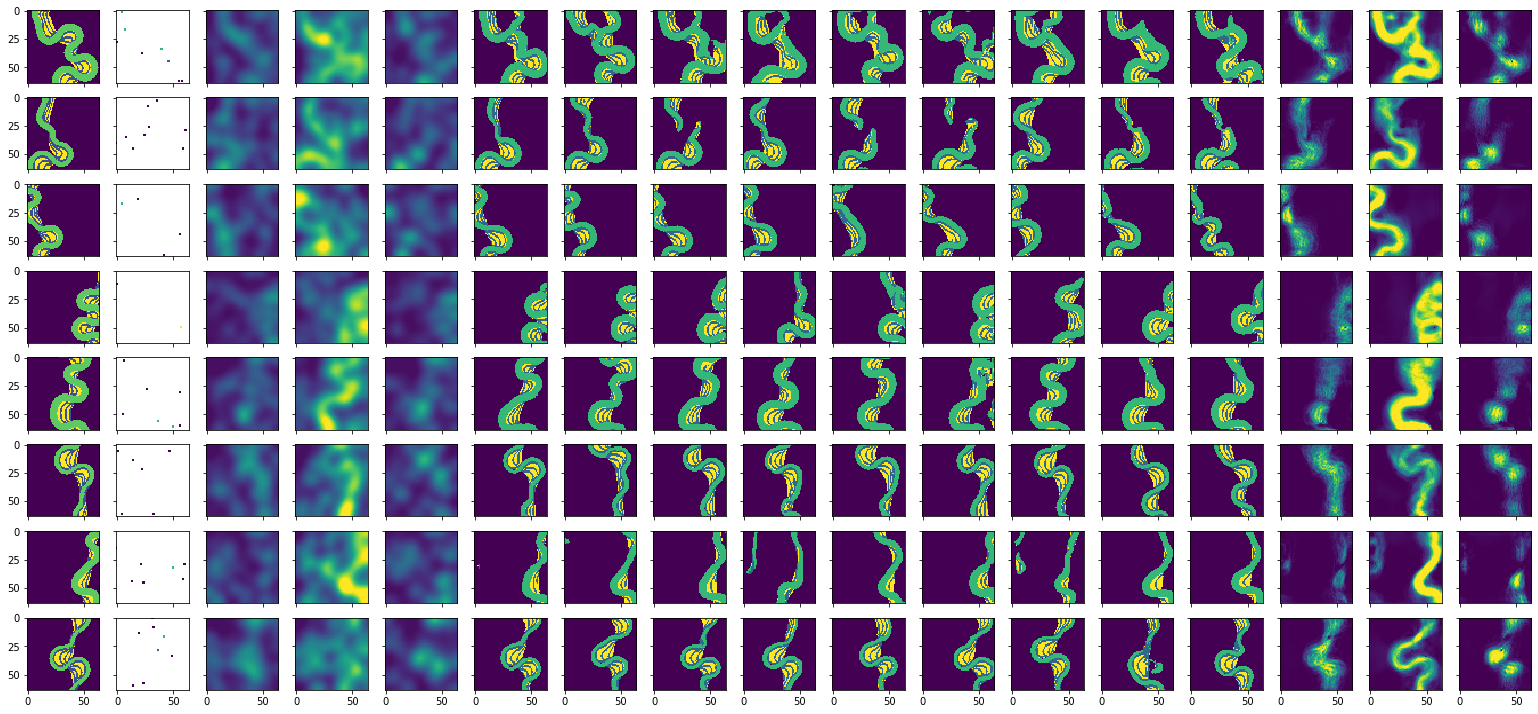

In [18]:
# 54-16960

fig, ax = plt.subplots(8, 17, sharex='col', sharey='row')
fig.set_size_inches(27, 12.5, forward=True)

images_plt_average = np.zeros((8,1,64,64))
for i in range (8):


    ax[i, 0].imshow(facies_test[i+1,0,:,:])  # *15+50 is to create inconsistency between labels and probimg
    ax[i, 1].imshow(wellfacies_onechannel_mask[i+1,0], cmap=cmap_well, vmax = 4)
    ax[i, 2].imshow(probimgs_test[i + 1, 0].astype(np.float32), vmin = 0, vmax = 0.5)
    ax[i, 3].imshow(probimgs_test[i + 1, 1].astype(np.float32), vmin = 0, vmax = 0.5)
    ax[i, 4].imshow(probimgs_test[i + 1, 2].astype(np.float32), vmin = 0, vmax = 0.5)
    
    real_num = 100
    latents_plt = np.random.RandomState(410).randn(real_num, Gs.input_shapes[0][1], Gs.input_shapes[0][2], Gs.input_shapes[0][3])

    labels_plt = np.tile(np.expand_dims(np.expand_dims(labels_test[i+1:i+2], axis = -1), axis = -1), (real_num, 1, 64, 64))  #
    wellfacies_plt = np.repeat(np.expand_dims(wellfaciesimgs_test_G[i+1], axis=0), real_num, axis=0)
    prob_plt = np.repeat(probimgs_test[i+1:i+2], real_num, axis=0)
    
    #np.zeros((real_num, Gs.input_shapes[3][1], Gs.input_shapes[3][2], Gs.input_shapes[3][3]))     
    fakemodel_indicators_plt = Gs.run(latents_plt, labels_plt, wellfacies_plt, prob_plt)
    fakemodels_plt = np.expand_dims(np.argmax(fakemodel_indicators_plt, axis = 1), axis = 1)
    
    fakemodel_freq_md = np.average(fakemodel_indicators_plt[:, 1], axis = 0)
    fakemodel_freq_cf = np.average(fakemodel_indicators_plt[:, 2], axis = 0)
    fakemodel_freq_la = np.average(fakemodel_indicators_plt[:, 3], axis = 0)

    for j in range(5,14):
        ax[i, j].imshow(fakemodels_plt[j-2,0,:,:])
    ax[i, 14].imshow(fakemodel_freq_md, vmin = 0, vmax = 0.5)
    ax[i, 15].imshow(fakemodel_freq_cf, vmin = 0, vmax = 0.5) 
    ax[i, 16].imshow(fakemodel_freq_la, vmin = 0, vmax = 0.5)   
#plt.savefig(network_dir + "Random Latents.png", dpi=200) 

In [19]:
TotalModel_no = 1000
latents = np.random.RandomState(412).randn(TotalModel_no, 8, 4, 4)
labels_ = np.tile(np.expand_dims(np.expand_dims(labels_test[:TotalModel_no], axis = -1), axis = -1), (1, 1, 64, 64))
print(labels_.shape)

wellfacies = wellfaciesimgs_test_G[:TotalModel_no]
prob = probimgs_test[:TotalModel_no]
#
fakemodel_indicators = Gs.run(latents, labels_, wellfacies, prob)
fakemodels = np.expand_dims(np.argmax(fakemodel_indicators, axis = 1), axis = 1)
print(fakemodels.shape)

wellfacies_newcode = np.where(wellfacies[:, 1:2] >2, wellfacies[:, 1:2] - 1, wellfacies[:, 1:2])
recognized = np.where(wellfacies_newcode==fakemodels, 1, 0) * wellfacies[:, 0:1]
acc = np.sum(recognized)/np.sum(wellfacies[:, 0:1])

print(acc)

(1000, 2, 64, 64)
(1000, 1, 64, 64)
1.0


#### (1) Test case 1

In [40]:
d_ = (fp_prop - 0.74)**2 + (pb_cf_ratio - 1.14)**2
test_num = np.argsort(d_)[0]

print(test_num)
print(d_[test_num])
print(fp_prop[test_num])
print(pb_cf_ratio[test_num])

82
6.094283e-05
0.74658203
1.1358024


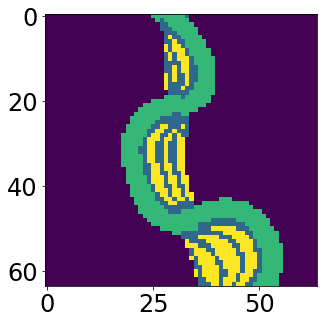

In [21]:
# Ground truth

plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5, 5, forward=True)

ax.imshow(facies_test_newcode[test_num,0,:,:])

#plt.savefig(GANSim_dir + "Case1_ground_truth.png", dpi=200) 


In [22]:
# Generate more complex well facies points for illustration
well_points_test_illu = np.zeros((1, 1, 64, 64), dtype = np.int8)
for i in range(well_points_test_illu.shape[0]):
    well_points_num = 8  # Random choose the expected total number of well points
    xs = np.random.RandomState(12).choice(well_points_test_illu.shape[2], well_points_num)
    ys = np.random.RandomState(371).choice(well_points_test_illu.shape[3], well_points_num)
    well_points_test_illu[i, 0, xs, ys] = 1
    
well_facies_test_illu = facies_test[test_num:test_num+1] * well_points_test_illu
well_facies_test_illu = well_facies_test_illu + well_points_test_illu
print(well_facies_test_illu.shape)

wellfaciesimgs_test_loc_illu = np.where(well_facies_test_illu>0, 1, 0)
wellfaciesimgs_test_fc_illu = (well_facies_test_illu - 1) * wellfaciesimgs_test_loc_illu
wellfaciesimgs_test_G_illu = np.concatenate([wellfaciesimgs_test_loc_illu, wellfaciesimgs_test_fc_illu], axis = 1)
print(wellfaciesimgs_test_G_illu.shape)

well_facies_test_illu_newcode = np.where(well_facies_test_illu>2, well_facies_test_illu - 1, well_facies_test_illu)
wellfacies_onechannel_illu = enlarge(well_facies_test_illu_newcode)
wellfacies_onechannel_mask_illu = np.ma.masked_where(wellfacies_onechannel_illu == 0, wellfacies_onechannel_illu)

(1, 1, 64, 64)
(1, 2, 64, 64)


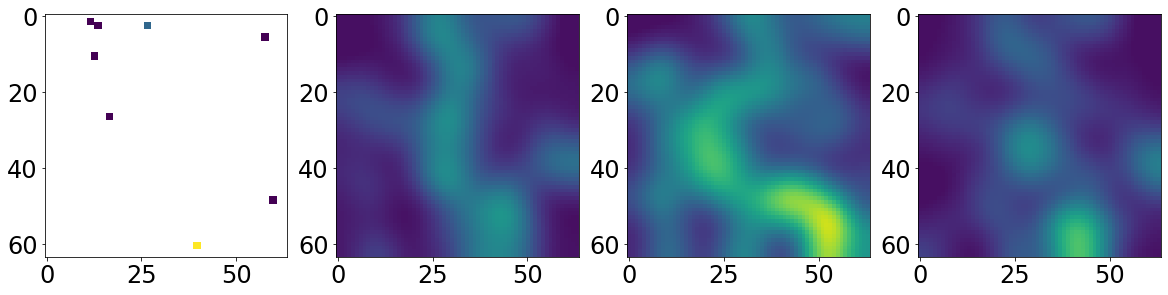

In [23]:
# Well facies data and probability maps
plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(1, 4)
fig.set_size_inches(20, 5, forward=True)

ax[0].imshow(wellfacies_onechannel_mask_illu[0, 0], cmap=cmap_well, vmin = 1, vmax = 4)
ax[1].imshow(probimgs_test[test_num, 0].astype(np.float32), vmin = 0, vmax = 0.5)
ax[2].imshow(probimgs_test[test_num, 1].astype(np.float32), vmin = 0, vmax = 0.5)
ax[3].imshow(probimgs_test[test_num, 2].astype(np.float32), vmin = 0, vmax = 0.5)

#plt.savefig(GANSim_dir + "Case1_well_prob.png", dpi=200) 

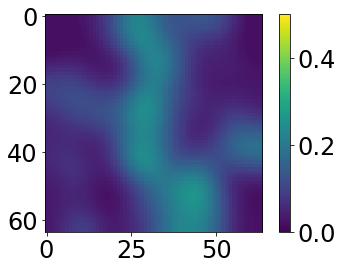

In [24]:
plt.imshow(probimgs_test[test_num, 0].astype(np.float32), vmin = 0, vmax = 0.5)
plt.colorbar()

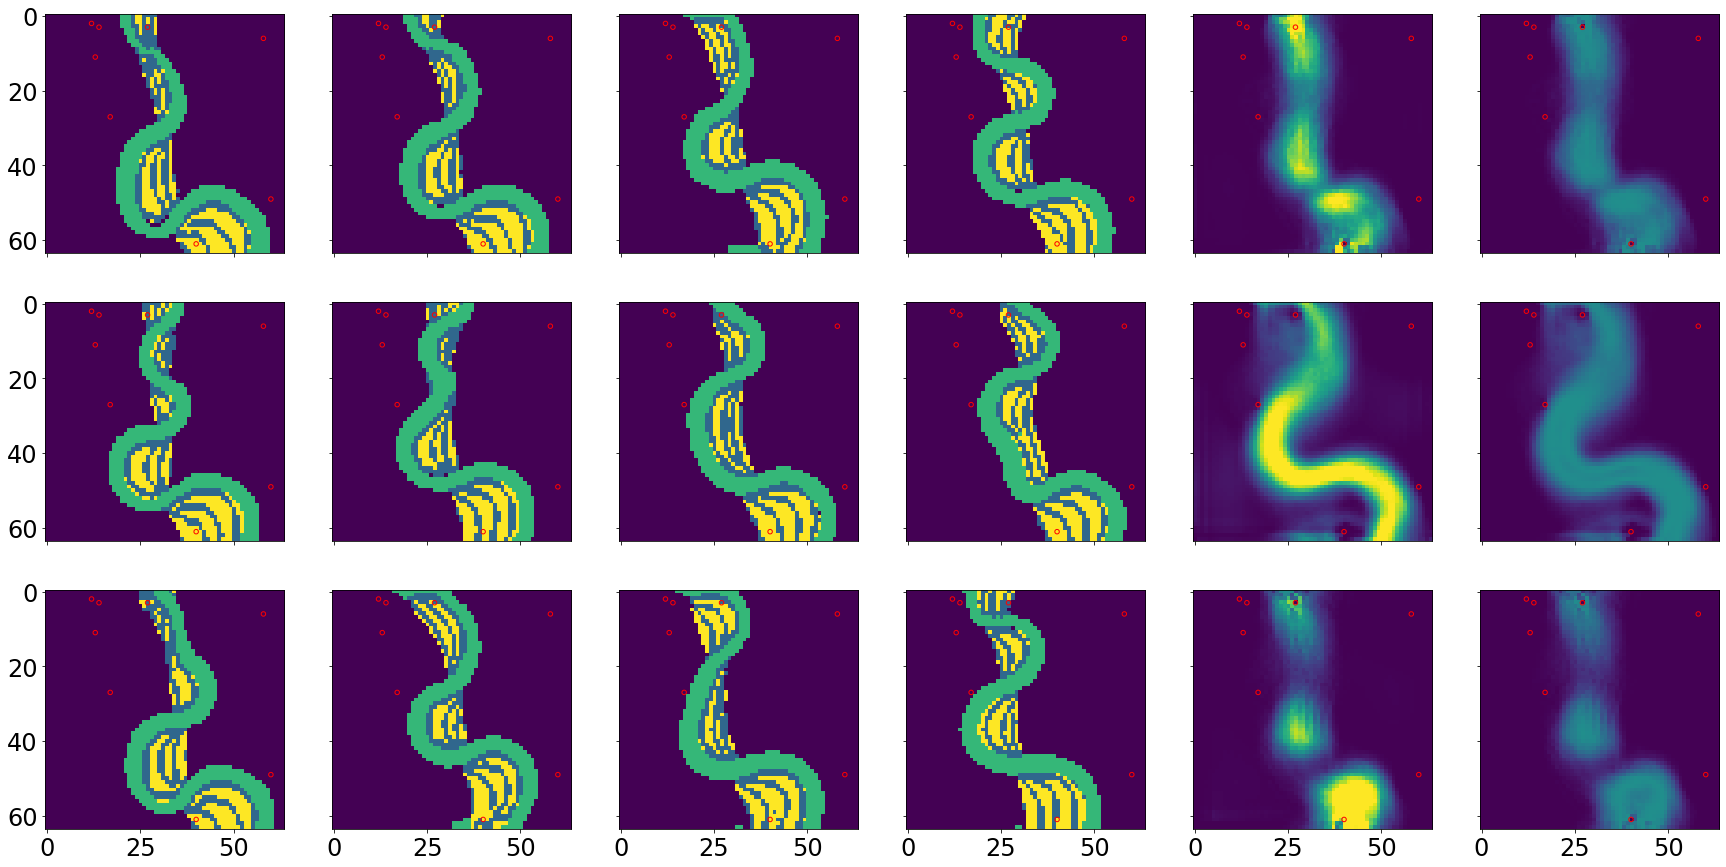

In [25]:
# Several realizations and mean and std

real_num = 1000
latents_plt = np.random.RandomState(410).randn(real_num, Gs.input_shapes[0][1], Gs.input_shapes[0][2], Gs.input_shapes[0][3])
labels_plt = np.tile(np.expand_dims(np.expand_dims(labels_test[test_num:test_num+1], axis = -1), axis = -1), (real_num, 1, 64, 64))  #
wellfacies_plt = np.repeat(wellfaciesimgs_test_G_illu, real_num, axis=0)
prob_plt = np.repeat(probimgs_test[test_num:test_num+1], real_num, axis=0)
 
fakemodel_indicators_plt = Gs.run(latents_plt, labels_plt, wellfacies_plt, prob_plt)
fakemodels_plt = np.expand_dims(np.argmax(fakemodel_indicators_plt, axis = 1), axis = 1)

fakemodel_freq_md = np.average(fakemodel_indicators_plt[:, 1], axis = 0)
fakemodel_var_md = np.var(fakemodel_indicators_plt[:, 1], axis = 0)
fakemodel_freq_cf = np.average(fakemodel_indicators_plt[:, 2], axis = 0)
fakemodel_var_cf = np.var(fakemodel_indicators_plt[:, 2], axis = 0)
fakemodel_freq_la = np.average(fakemodel_indicators_plt[:, 3], axis = 0)
fakemodel_var_la = np.var(fakemodel_indicators_plt[:, 3], axis = 0)

plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(3, 6, sharex='col', sharey='row')
fig.set_size_inches(30, 15, forward=True)
for i in range(3):
    for j in range(4):
        ax[i, j].imshow(fakemodels_plt[i*5+j+10, 0])
ax[0, 4].imshow(fakemodel_freq_md, vmin = 0, vmax = 0.5) 
ax[0, 5].imshow(fakemodel_var_md, vmin = 0, vmax = 0.5) 
ax[1, 4].imshow(fakemodel_freq_cf, vmin = 0, vmax = 0.5) 
ax[1, 5].imshow(fakemodel_var_cf, vmin = 0, vmax = 0.5) 
ax[2, 4].imshow(fakemodel_freq_la, vmin = 0, vmax = 0.5) 
ax[2, 5].imshow(fakemodel_var_la, vmin = 0, vmax = 0.5) 

index_x=np.argwhere(wellfaciesimgs_test_G_illu[0, 0]>0)[:, 1]
index_y=np.argwhere(wellfaciesimgs_test_G_illu[0, 0]>0)[:, 0]
for i in range(3):
    for j in range(6):
        ax[i, j].scatter(index_x, index_y, s=20, marker='o', facecolor='none', edgecolor='red')

plt.savefig(GANSim_dir + "Case1_realizations.png", dpi=200) 

In [26]:
img_indc_fp_gansim = fakemodel_indicators_plt[:, 0:1]
img_indc_md_gansim = fakemodel_indicators_plt[:, 1:2]
img_indc_cf_gansim = fakemodel_indicators_plt[:, 2:3]
img_indc_sd_gansim = fakemodel_indicators_plt[:, 3:4]

pb_cf_ratio_gansim = (np.mean(img_indc_md_gansim, axis = (1, 2, 3)) + np.mean(img_indc_sd_gansim, axis = (1, 2, 3))) / np.mean(img_indc_cf_gansim, axis = (1, 2, 3))
print(pb_cf_ratio_gansim.shape)
fp_prop_gansim = np.mean(img_indc_fp_gansim, axis = (1, 2, 3))
print(fp_prop_gansim.shape)

(1000,)
(1000,)


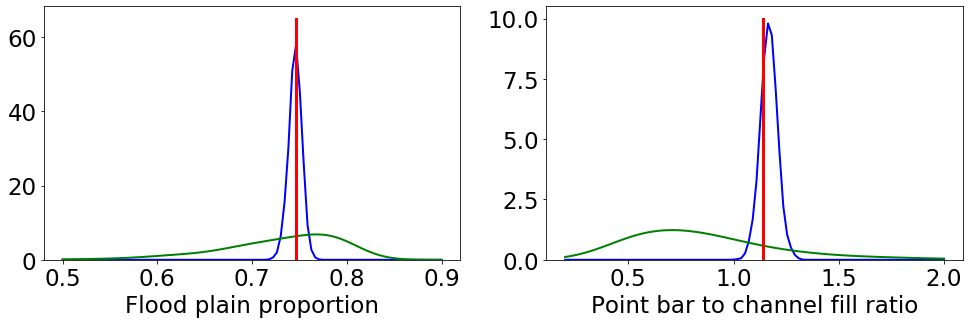

In [27]:
plt.rcParams.update({'font.size': 23})

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(14, 5)

from scipy.stats import gaussian_kde
x_range = np.linspace(0.5, 0.9, 100)  # Generate range of values for x-axis
kde_cond_gansim = gaussian_kde(fp_prop_gansim, bw_method=0.4)
pdf_values_cond_gansim = kde_cond_gansim(x_range)  # Compute PDF values for the range

kde = gaussian_kde(fp_prop, bw_method=0.4)
pdf_values = kde(x_range)  # Compute PDF values for the range
# Plot the PDFs on the same axis
ax[0].plot(x_range, pdf_values_cond_gansim, 'blue', linewidth=2, label='cond PDF')  # Plot PDF for mudprop_cond_R
ax[0].plot(x_range, pdf_values, 'g', linewidth=2, label='test PDF')  # Plot PDF for mudprop
ax[0].plot([0.746, 0.746], [0, 65], 'r-', linewidth=3)  # Increase linewidth for a bolder appearance
ax[0].set_ylim(bottom=0)
ax[0].set_xlabel('Flood plain proportion')

from scipy.stats import gaussian_kde
x_range = np.linspace(0.2, 2., 100)  # Generate range of values for x-axis
kde_cond_gansim = gaussian_kde(pb_cf_ratio_gansim, bw_method=0.4)
pdf_values_cond_gansim = kde_cond_gansim(x_range)  # Compute PDF values for the range

kde = gaussian_kde(pb_cf_ratio, bw_method=0.4)
pdf_values = kde(x_range)  # Compute PDF values for the range
# Plot the PDFs on the same axis
ax[1].plot(x_range, pdf_values_cond_gansim, 'blue', linewidth=2, label='cond PDF')  # Plot PDF for mudprop_cond_R
ax[1].plot(x_range, pdf_values, 'g', linewidth=2, label='test PDF')  # Plot PDF for mudprop
ax[1].plot([1.14, 1.14], [0, 10], 'r-', linewidth=3)  # Increase linewidth for a bolder appearance
ax[1].set_ylim(bottom=0)
ax[1].set_xlabel('Point bar to channel fill ratio')
# Adjust space between subplots
plt.subplots_adjust(wspace=0.25)

# Use tight layout to prevent labels from being cut off
plt.tight_layout()

# Save the figure
plt.savefig(GANSim_dir + "GlobalFeature_histograms.jpg", dpi=100)



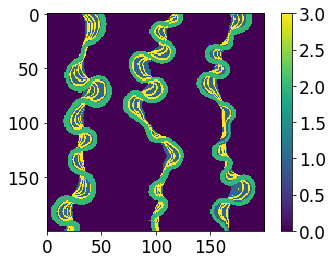

In [28]:
MPS_dir = '/scratch/users/suihong/Mud_drape_Channels/MPS/TI_large/'
TI_final_loaded = np.load(MPS_dir + "Unc_point_TI.npy")

plt.rcParams.update({'font.size': 17})

plt.imshow(TI_final_loaded)
plt.colorbar()

In [29]:
np.savetxt(GANSim_dir + 'Cond_Point_Case1_Ref.txt', facies_test_newcode[test_num,0,:,:], fmt='%d', delimiter=',')

well_mps = wellfaciesimgs_test_G_illu[0]
well_mps[1] = np.where(well_mps[1] > 2, well_mps[1] - 1, well_mps[1])
np.savetxt(GANSim_dir + 'Cond_Point_Case1_well.txt', well_mps.reshape(-1, 64), fmt='%d', delimiter=',')
np.savetxt(GANSim_dir + 'Cond_Point_Case1_prob.txt', probimgs_test[test_num].reshape(-1, 64), fmt='%.3f', delimiter=',')
#np.savetxt(GANSim_dir + 'Cond_Point_Case1_TI.txt', TIs_large_load[7, 0, :,:], fmt = '%d', delimiter=',')


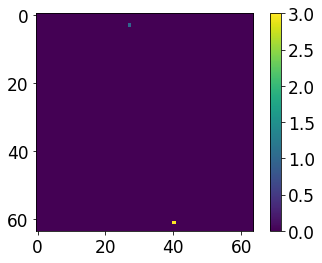

In [30]:
loaded_matrix = np.loadtxt(GANSim_dir + 'Cond_Point_Case1_well.txt', delimiter=',', dtype=int).reshape(-1, 64, 64)

plt.imshow(loaded_matrix[1])
plt.colorbar()

#### (3) Generation of lage geomodels

In [84]:
tf.disable_v2_behavior()  # if not use with this line, "AttributeError: 'int' object has no attribute 'value'" 
#tf.disable_eager_execution()

import config
import tfutil

resolution_x = 192
resolution_y = 192

latent_size_x = int(resolution_x/16)  # 16
latent_size_y = int(resolution_y/16)  # 23

#label_size = 0

Gs_enlarged = tfutil.Network('Gs_enlarged1', 
                             resolution_x = resolution_x, resolution_y = resolution_y,
                             latent_size_x = latent_size_x, latent_size_y = latent_size_y,    
                             **config.G) #

In [85]:
print(Gs_enlarged.input_shapes)

[[Dimension(None), Dimension(8), Dimension(12), Dimension(12)], [Dimension(None), Dimension(2), Dimension(192), Dimension(192)], [Dimension(None), Dimension(2), Dimension(192), Dimension(192)], [Dimension(None), Dimension(3), Dimension(192), Dimension(192)]]


In [86]:
Gs_enlarged.print_layers()


Gs_enlarged1                Params      OutputShape             WeightShape             
---                         ---         ---                     ---                     
latents_in                  -           (?, 8, 12, 12)          -                       
labels_in                   -           (?, 2, 192, 192)        -                       
wellfacies_in               -           (?, 2, 192, 192)        -                       
probimgs_in                 -           (?, 3, 192, 192)        -                       
lod                         -           ()                      -                       
stage1_4/Conv0              7008        (?, 96, 12, 12)         (3, 3, 8, 96)           
stage1_4/Conv1              83040       (?, 96, 12, 12)         (3, 3, 96, 96)          
stage1_4/Add_Label          6           (?, 2, 12, 12)          (1, 1, 2, 2)            
stage1_4/Add_Prob           32          (?, 8, 12, 12)          (1, 1, 3, 8)            
stage1_4/Add_Wellfc 

In [87]:
Gs_enlarged.list_layers()

[('latents_in',
  <tf.Tensor 'Gs_enlarged1_2/latents_in:0' shape=(?, 8, 12, 12) dtype=float32>,
  []),
 ('labels_in',
  <tf.Tensor 'Gs_enlarged1_2/labels_in:0' shape=(?, 2, 192, 192) dtype=float32>,
  []),
 ('wellfacies_in',
  <tf.Tensor 'Gs_enlarged1_2/wellfacies_in:0' shape=(?, 2, 192, 192) dtype=float32>,
  []),
 ('probimgs_in',
  <tf.Tensor 'Gs_enlarged1_2/probimgs_in:0' shape=(?, 3, 192, 192) dtype=float32>,
  []),
 ('lod', <tf.Tensor 'Gs_enlarged1_2/lod/read:0' shape=() dtype=float32>, []),
 ('stage1_4/Conv0',
  <tf.Tensor 'Gs_enlarged1_2/stage1_4/Conv0/PixelNorm/mul:0' shape=(?, 96, 12, 12) dtype=float32>,
  [<tf.Tensor 'Gs_enlarged1_2/stage1_4/Conv0/weight:0' shape=(3, 3, 8, 96) dtype=float32_ref>,
   <tf.Tensor 'Gs_enlarged1_2/stage1_4/Conv0/bias:0' shape=(96,) dtype=float32_ref>]),
 ('stage1_4/Conv1',
  <tf.Tensor 'Gs_enlarged1_2/stage1_4/Conv1/PixelNorm/mul:0' shape=(?, 96, 12, 12) dtype=float32>,
  [<tf.Tensor 'Gs_enlarged1_2/stage1_4/Conv1/weight:0' shape=(3, 3, 96, 96) dt

In [88]:
Gs.list_layers()

[('latents_in',
  <tf.Tensor 'Gs/latents_in:0' shape=(?, 8, 4, 4) dtype=float32>,
  []),
 ('labels_in',
  <tf.Tensor 'Gs/labels_in:0' shape=(?, 2, 64, 64) dtype=float32>,
  []),
 ('wellfacies_in',
  <tf.Tensor 'Gs/wellfacies_in:0' shape=(?, 2, 64, 64) dtype=float32>,
  []),
 ('probimgs_in',
  <tf.Tensor 'Gs/probimgs_in:0' shape=(?, 3, 64, 64) dtype=float32>,
  []),
 ('lod', <tf.Tensor 'Gs/lod/ReadVariableOp:0' shape=() dtype=float32>, []),
 ('stage1_4/Conv0',
  <tf.Tensor 'Gs/stage1_4/Conv0/bias/ReadVariableOp:0' shape=(96,) dtype=float32>,
  []),
 ('stage1_4/Conv1',
  <tf.Tensor 'Gs/stage1_4/Conv1/bias/ReadVariableOp:0' shape=(96,) dtype=float32>,
  []),
 ('stage1_4/Add_Label',
  <tf.Tensor 'Gs/stage1_4/Add_Label/bias/ReadVariableOp:0' shape=(2,) dtype=float32>,
  []),
 ('stage1_4/Add_Prob',
  <tf.Tensor 'Gs/stage1_4/Add_Prob/bias/ReadVariableOp:0' shape=(8,) dtype=float32>,
  []),
 ('stage1_4/Add_Wellfc',
  <tf.Tensor 'Gs/stage1_4/Add_Wellfc/Conv0/bias/ReadVariableOp:0' shape=(4,) dt

In [89]:
Gs_enlarged.copy_trainables_from(Gs)

In [90]:
#Gs.copy_trainables_from(Gs_enlarged)

In [91]:
geomodel_large_truth = TI_final_loaded[np.newaxis, np.newaxis, :, :]

# Generate random well points
geomodel_large_truth_wellpoints = np.zeros(geomodel_large_truth.shape, dtype = np.int8)
for i in range(1):
    well_points_num = 25 #np.random.RandomState(3*i + i*i).choice(np.arange(1, 25), 1)  # Random choose the expected total number of well points
    xs = np.random.RandomState(123*i+22).choice(geomodel_large_truth.shape[2], well_points_num)
    ys = np.random.RandomState(3*i + i*i+1111).choice(geomodel_large_truth.shape[3], well_points_num)
    geomodel_large_truth_wellpoints[i, 0, xs, ys] = 1
    
geomodel_large_truth_wellfacies = geomodel_large_truth * geomodel_large_truth_wellpoints

geomodel_large_truth_wellfacies = np.concatenate((geomodel_large_truth_wellpoints, geomodel_large_truth_wellfacies), axis = 1)
geomodel_large_truth_wellfacies = geomodel_large_truth_wellfacies[:, :, :resolution_x, :resolution_y]

print(geomodel_large_truth_wellfacies.shape)

(1, 2, 192, 192)


In [92]:
def noise(img, max_noise_size):
    img_x = img.shape[0]
    img_y = img.shape[1]
    img_noise = np.zeros(img.shape)
    # (1) add noise within the facies of indicator = 1 
    noise_num_max = np.round(np.sum(img)/40)
    if noise_num_max>0:       
        ind_indices = np.argwhere(img>=0.9)
        noise_num = np.random.RandomState(123).randint(0, noise_num_max)
        noise_indices = np.random.RandomState(123).randint(0, ind_indices.shape[0], noise_num)    
        noise_coos = ind_indices[noise_indices]
        noise_sizes = np.random.RandomState(123).randint(3, max_noise_size, noise_num)  
        noise_values = np.random.RandomState(123).uniform(-2., 1.5, noise_num)
        for i in range(noise_num):
            noise_coo_i_x = noise_coos[i, 0]
            noise_coo_i_y = noise_coos[i, 1]
            noise_size_i = noise_sizes[i]
            noise_value_i = noise_values[i]
            img_noise[noise_coo_i_x:min(img_x, noise_coo_i_x + noise_size_i), noise_coo_i_y:min(img_y, noise_coo_i_y + noise_size_i)]=noise_value_i
   
    # (2) add noise within the facies of indicator = 0
    noise_num_max = np.round((img_x*img_y - np.sum(img))/40)
    if noise_num_max>0:
        ind_indices = np.argwhere(img<=0.1)
        noise_num = np.random.RandomState(123).randint(0, noise_num_max)
        noise_indices = np.random.RandomState(123).randint(0, ind_indices.shape[0], noise_num)    
        noise_coos = ind_indices[noise_indices]
        noise_sizes = np.random.RandomState(123).randint(3, max_noise_size, noise_num)  
        noise_values = np.random.RandomState(123).uniform(0., 1., noise_num)
        for i in range(noise_num):
            noise_coo_i_x = noise_coos[i, 0]
            noise_coo_i_y = noise_coos[i, 1]
            noise_size_i = noise_sizes[i]
            noise_value_i = noise_values[i]
            img_noise[noise_coo_i_x:min(img_x, noise_coo_i_x + noise_size_i), noise_coo_i_y:min(img_y, noise_coo_i_y + noise_size_i)]=noise_value_i
    return img_noise

# Using Gaussian kernels with various size to smooth the indicator of underground-river-related cave facies to form the probability maps of caves with various blurriness. 
from scipy import ndimage

geomodel_large_truth_prob = np.zeros((geomodel_large_truth.shape[0], 3, geomodel_large_truth.shape[2], geomodel_large_truth.shape[3]), dtype=np.float16) 
for num in range(geomodel_large_truth_prob.shape[0]):  
    if num % 100 == 0:
        print(num)  
    k = np.random.RandomState(123).choice([3., 4., 5.])
    
    geomodel_large_truth_indc_md = np.where(geomodel_large_truth == 1, 1, 0)
    geomodel_large_truth_indc_cf = np.where(geomodel_large_truth == 2, 1, 0)
    geomodel_large_truth_indc_sd = np.where(geomodel_large_truth == 3, 1, 0)
    
    cur_indc_md = geomodel_large_truth_indc_md[num, 0].astype(np.float32)
    cur_indc_fc = geomodel_large_truth_indc_cf[num, 0].astype(np.float32)
    cur_indc_sd = geomodel_large_truth_indc_sd[num, 0].astype(np.float32)
    cur_indc_md_noise = noise(cur_indc_md, 6)
    cur_indc_fc_noise = noise(cur_indc_fc, 9) 
    cur_indc_sd_noise = noise(cur_indc_sd, 6)
    cur_noise_prob_md = ndimage.gaussian_filter(cur_indc_md_noise, sigma = (k, k), mode = 'reflect')
    cur_noise_prob_fc = ndimage.gaussian_filter(cur_indc_fc_noise, sigma = (k, k), mode = 'reflect') 
    cur_noise_prob_sd = ndimage.gaussian_filter(cur_indc_sd_noise, sigma = (k, k), mode = 'reflect') 
    prob_md_without_noise = ndimage.gaussian_filter(cur_indc_md, sigma = (k, k), mode = 'reflect') 
    prob_fc_without_noise = ndimage.gaussian_filter(cur_indc_fc, (k, k), mode = 'reflect') 
    prob_sd_without_noise = ndimage.gaussian_filter(cur_indc_sd, (k, k), mode = 'reflect')
    prob_md = prob_md_without_noise + cur_noise_prob_md
    prob_fc = prob_fc_without_noise + cur_noise_prob_fc 
    prob_sd = prob_sd_without_noise + cur_noise_prob_sd 

    prob_sum = prob_md + prob_fc + prob_sd  
    prob_sum_max = np.amax(prob_sum, axis = (0,1))
    if prob_sum_max<0.25:  # amplify the prob range beyond (0-0.25)
        prob_mx = np.random.RandomState(123).rand(1)*0.45+0.25
        prob_md = prob_md * prob_mx / prob_sum_max   
        prob_fc = prob_fc * prob_mx / prob_sum_max 
        prob_sd = prob_sd * prob_mx / prob_sum_max 
    
    if prob_sum_max>0.9: 
        prob_md = prob_md / prob_sum_max * 0.9
        prob_fc = prob_fc / prob_sum_max * 0.9
        prob_sd = prob_sd / prob_sum_max * 0.9
    
    geomodel_large_truth_prob[num, 0] = prob_md 
    geomodel_large_truth_prob[num, 1] = prob_fc
    geomodel_large_truth_prob[num, 2] = prob_sd
    
    geomodel_large_truth_prob[num] = np.where(geomodel_large_truth_prob[num]<0.02, 0.02, geomodel_large_truth_prob[num]) 
    
geomodel_large_truth_prob = geomodel_large_truth_prob[:, :, :resolution_x, :resolution_y]
print(geomodel_large_truth_prob.shape)

0
(1, 3, 192, 192)


In [93]:
geomodel_large_truth.shape

(1, 1, 200, 200)

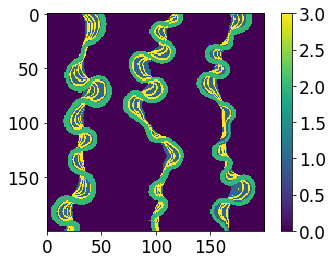

In [94]:
plt.imshow(geomodel_large_truth[0,0])
plt.colorbar()

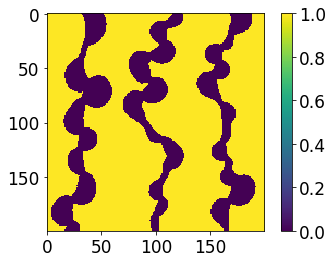

In [95]:
geomodel_large_truth_mudprop = np.where(geomodel_large_truth==0, 1, 0)

plt.imshow(geomodel_large_truth_mudprop[0,0])
plt.colorbar()

(200, 200)


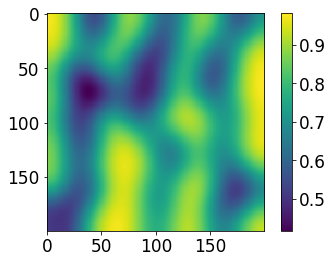

In [96]:
geomodel_large_truth_mudprop = np.where(geomodel_large_truth==0, 1, 0).astype(np.float32)
geomodel_large_truth_mudprop_smt = ndimage.gaussian_filter(geomodel_large_truth_mudprop[0,0], sigma = (15, 15), mode = 'reflect')
print(geomodel_large_truth_mudprop_smt.shape)

plt.imshow(geomodel_large_truth_mudprop_smt)
plt.colorbar()

In [97]:
labels_plt.shape

(100, 2, 128, 192)

In [98]:
real_num = 100
latents_plt = np.random.RandomState(410).randn(real_num, Gs_enlarged.input_shapes[0][1], Gs_enlarged.input_shapes[0][2], Gs_enlarged.input_shapes[0][3])
labels_plt = np.tile(np.expand_dims(np.expand_dims(labels_test[test_num:test_num+1], axis = -1), axis = -1), (real_num, 1, resolution_x, resolution_y))  #
#labels_plt[:, 30] = np.expand_dims(geomodel_large_truth_mudprop_smt[:resolution_x, :resolution_y], axis = 0)

wellfacies_plt = np.repeat(geomodel_large_truth_wellfacies, real_num, axis=0)
prob_plt = np.repeat(geomodel_large_truth_prob, real_num, axis=0)
 
fakemodel_indicators_plt = Gs_enlarged.run(latents_plt, labels_plt, wellfacies_plt, prob_plt)
fakemodels_plt = np.expand_dims(np.argmax(fakemodel_indicators_plt, axis = 1), axis = 1)
    
fakemodel_freq_ch = np.average(fakemodel_indicators_plt[:, 2], axis = 0)
fakemodel_var_ch = np.var(fakemodel_indicators_plt[:, 2], axis = 0)   
fakemodel_freq_bk = np.average(fakemodel_indicators_plt[:, 1], axis = 0)
fakemodel_var_bk = np.var(fakemodel_indicators_plt[:, 1], axis = 0)


In [99]:
fakemodels_plt.shape

(100, 1, 192, 192)

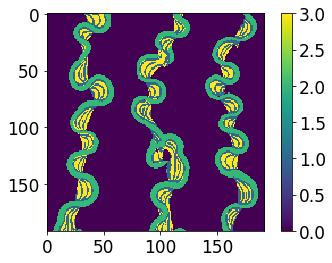

In [102]:
plt.imshow(fakemodels_plt[0, 0])
plt.colorbar()

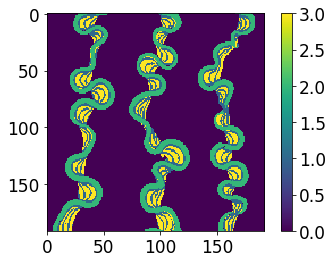

In [103]:
plt.imshow(fakemodels_plt[1, 0])
plt.colorbar()

In [101]:

plt.imshow(labels_plt[0, 30])
plt.colorbar()

IndexError: index 30 is out of bounds for axis 1 with size 2

In [ ]:
plt.imshow(fakemodel_freq_ch)
plt.colorbar()

In [ ]:
plt.imshow(prob_plt[0, 0].astype(np.float32))
plt.colorbar()

In [ ]:
plt.imshow(prob_plt[0, 1].astype(np.float32))
plt.colorbar()

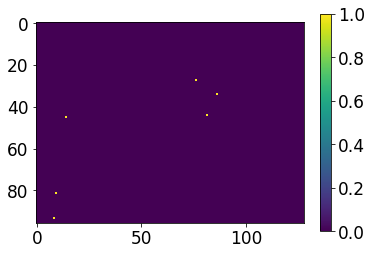

In [64]:
plt.imshow(wellfacies_plt[0, 0].astype(np.float32))
plt.colorbar()

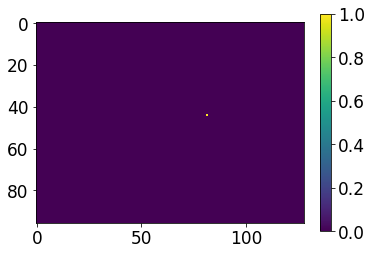

In [66]:
plt.imshow(wellfacies_plt[0, 1].astype(np.float32))
plt.colorbar()